# Deep Learning Final - Sentiment Analysis with LSTM and BERT

### In this notebook we'll develop and compare models on a Sentiment Analysis Task. We'll develop a RNN model with an LSTM layer from scratch and compare with transfer learning approach, using Google's BERT tranformer architecture

In [35]:
!pip install transformers==4.37.2

In [11]:
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade

In [12]:
!pip install tensorflow-text

### Importing the necessary libraries

In [13]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import transformers
import tokenizers

import re,string,unicodedata
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

In [14]:
import keras_nlp

In [15]:
from nltk.corpus import stopwords

In [16]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
import numpy as np
import pandas as pd
import keras_core as keras
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Fetching the dataset from Google Drive

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## The dataset

In [19]:
df = pd.read_csv("drive/MyDrive/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [20]:
df.shape

(50000, 2)

## Exploratory Data Analysis

In [21]:
def display_reviews_distribution(df):
  '''
  This method receives a review dataframe and plots the
  distribution of positive and negative reviews
  '''
  sentiment_distribution = (
      df \
      .groupby('sentiment') \
      .count() \
      .reset_index()
    )

  plt.bar(sentiment_distribution['sentiment'].astype(str), sentiment_distribution['review'])
  plt.xlabel('Sentiment')
  plt.ylabel('Count')
  plt.title('Negative / Positive Reviews')
  plt.show()

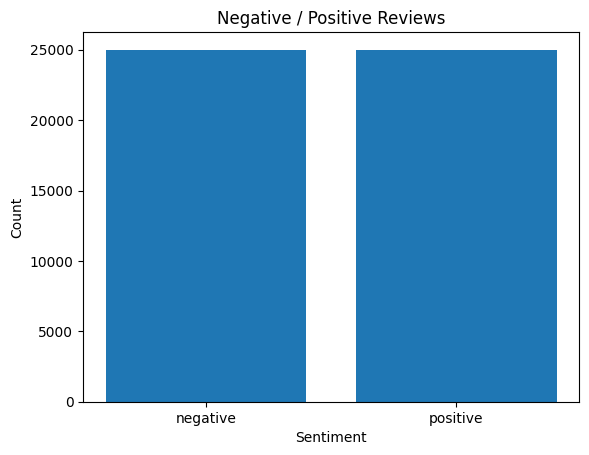

In [22]:
display_reviews_distribution(df)

From the plot, we observe that the dataset is balanced.

### Data Cleaning

In [23]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [24]:
def strip_html(text):
    '''
    This method removes HTML tags from the text
    '''
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [25]:
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

In [26]:
def remove_between_square_brackets(text):
    '''
    This method removes URL's from the text
    '''
    return re.sub(r'http\S+', '', text)

In [27]:
def remove_stopwords(text):
    '''
    This method removes stopwords from the text
    '''
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)

In [28]:
def clean_text(text):
    '''
    This invokes the previous methods to clean the text
    '''
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

In [40]:
df['review']=df['review'].apply(clean_text)

### Word Cloud

In [43]:
from wordcloud import WordCloud,STOPWORDS

In [44]:
def display_wordcloud(df, *sentiments):
  '''
  This method displays the wordcloud for the positive and negative reviews
  '''
  for sentiment in sentiments:
    data = df[df['sentiment'] == sentiment]['review']
    data_string = ' '.join(positive_data)
    plt.figure(figsize = (20,20))
    wc = WordCloud(max_words = 2000, width=1200, height=600,background_color="white").generate(data_string)
    plt.imshow(wc , interpolation = 'bilinear')
    plt.axis('off')
    plt.title(f'Word cloud for {sentiment} reviews',fontsize = 20)
    plt.show()

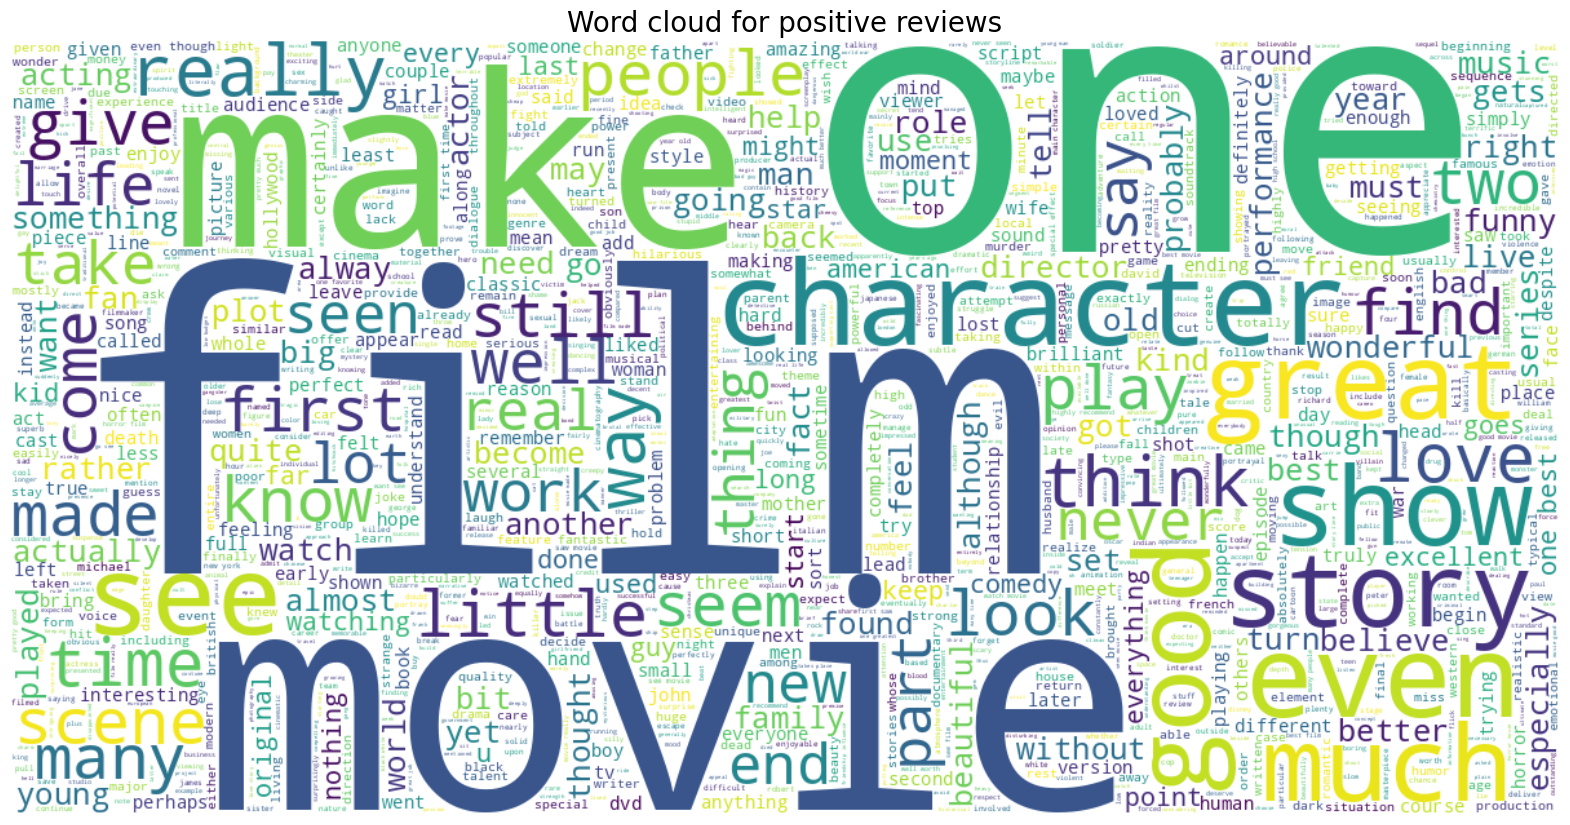

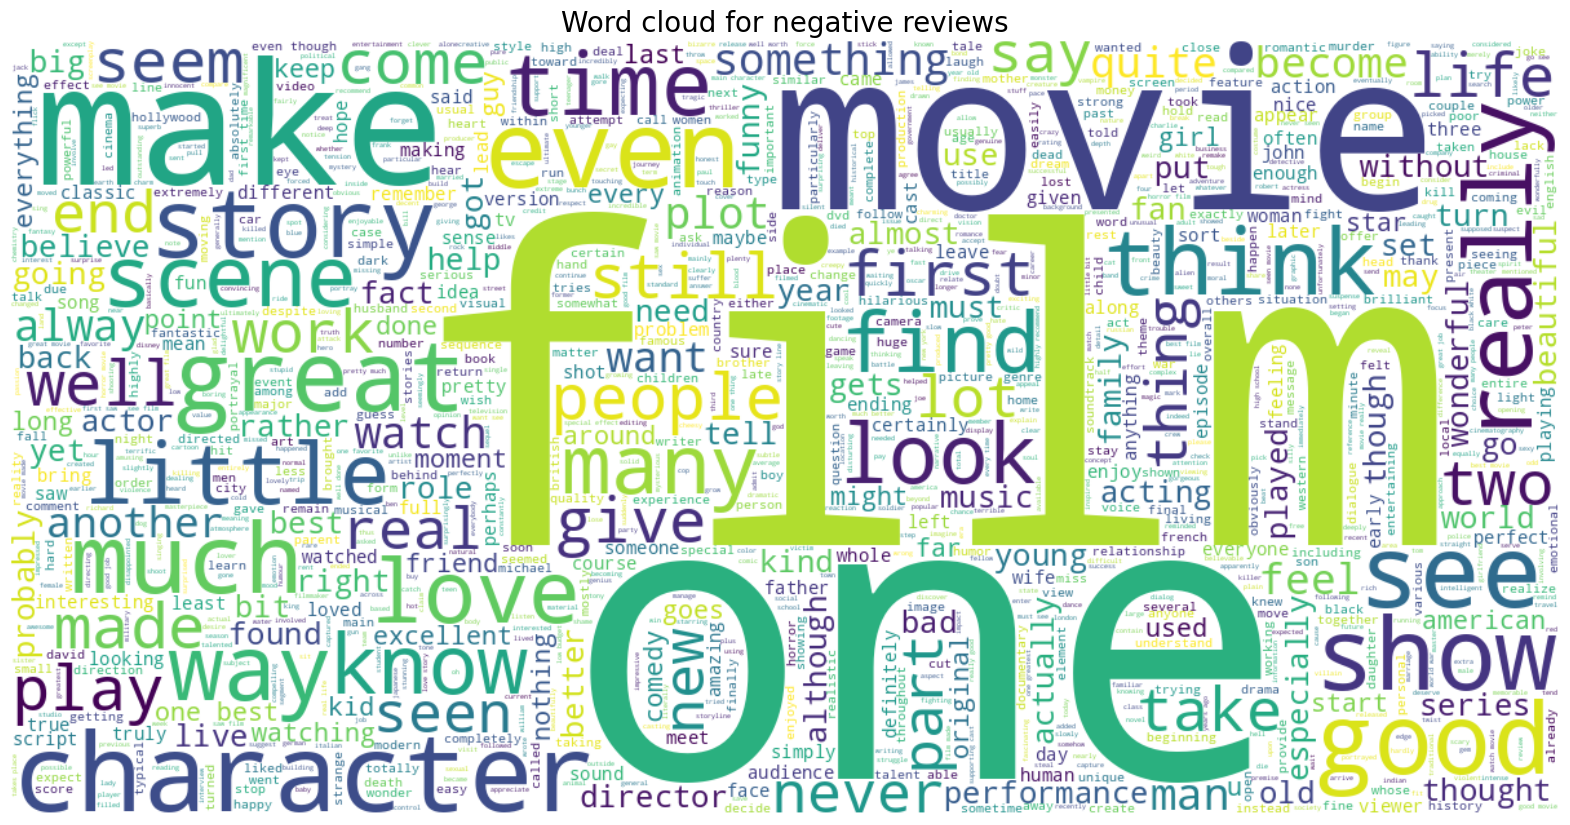

In [45]:
display_wordcloud(df, 'positive', 'negative')

### One Hot Encoding of Sentiment Column

In [41]:
df.sentiment.replace("positive" , 1 , inplace = True)
df.sentiment.replace("negative" , 0 , inplace = True)
df.head()

,review,sentiment
0,one reviewers mentioned watching oz episode ex...,1
1,wonderful little filming technique fashion giv...,1
2,thought wonderful way spend time hot summer si...,1
3,basically family little boy thinks zombie clos...,0
4,petter time visually stunning film mattei offe...,1


## Model Development

### In this section we'll develop an LSTM model and make use of Transfer Learning and also train a BERT model, and compare results

In [42]:
df_neg = df[df['sentiment'] == 0].sample(5000)
df_pos = df[df['sentiment'] == 1].sample(5000)
df_balanced = pd.concat([df_neg, df_pos]).sample(frac=1).reset_index(drop=True)
df_balanced.head()

,review,sentiment
0,perhaps one worst teenage slasher films ever s...,0
1,biblical film story judgment others see story ...,1
2,peculiar setting last opera definitely grew fi...,1
3,early jackie chan film sign chan persona chan ...,0
4,hines perpetrators begin wrong foot first assu...,0


# LSTM

LSTMs (Long Short-Term Memory units) are a type of neural network designed to remember information over long sequences, making them effective for tasks like language translation and time series prediction. Unlike regular RNNs, LSTMs can avoid issues like the vanishing gradient problem, allowing them to learn long-term dependencies in data.

### Train Test Split

In [51]:
train, test= train_test_split(df_balanced, test_size=0.2, random_state=42)
Xtrain, ytrain = train['review'], train['sentiment']
Xtest, ytest = test['review'], test['sentiment']

### Model Configuration

In [52]:
#set up the tokenizer
MAX_VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE,oov_token="<oov>")
tokenizer.fit_on_texts(Xtrain)
word_index = tokenizer.word_index
V = len(word_index)
print("Vocabulary of the dataset is : ",V)

Vocabulary of the dataset is :  39704


In [53]:
seq_train = tokenizer.texts_to_sequences(Xtrain)
seq_test =  tokenizer.texts_to_sequences(Xtest)

In [54]:
#choice of maximum length of sequences
seq_len_list = [len(i) for i in seq_train + seq_test]

#if we take the direct maximum then
max_len=max(seq_len_list)
print('Maximum length of sequence in the list: {}'.format(max_len))

Maximum length of sequence in the list: 773


In [55]:
# when setting the maximum length of sequence, variability around the average is used.
max_seq_len = np.mean(seq_len_list) + 2 * np.std(seq_len_list)
max_seq_len = int(max_seq_len)

Maximum length of the sequence when considering data only two standard deviations from average: 225


###

In [56]:
pad_train=pad_sequences(seq_train,truncating = 'post', padding = 'pre',maxlen=max_seq_len)
pad_test=pad_sequences(seq_test,truncating = 'post', padding = 'pre',maxlen=max_seq_len)

In [57]:
Xtrain,Xval,ytrain,yval=train_test_split(pad_train,ytrain,
                                             test_size=0.2,random_state=10)

## Model Architecture

We'll be using a traditional architecture with:
 - an Embedding Layer, converting words into dense vector Representations
 - Batch Normalization, boosting Gradient Descents derivatives calculations
 - Dropout for regularization
 - Biderectional LSTM layer for memory and Context

 For optmizer algorithm, we'll use Adam, with binary_crossentropy for loss, once it's a binary classification task
 We'll train over 5 epochs, with a minibatch size of 32

In [58]:
def lstm_model(Xtrain,Xval,ytrain,yval,V,D,maxlen,epochs):
    i = Input(shape=(maxlen,))
    x = Embedding(V + 1, D,input_length = maxlen)(i)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv1D(32,5,activation = 'relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling1D(2)(x)
    x = Bidirectional(LSTM(128,return_sequences=True))(x)
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    model.summary()

    print("----Training the network----")
    model.compile(optimizer= Adam(0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

    r = model.fit(Xtrain,ytrain,
                  validation_data = (Xval,yval),
                  epochs = epochs,
                  verbose = 2,
                  batch_size = 32)
                  #callbacks = callbacks
    print("Train score:", model.evaluate(Xtrain,ytrain))
    print("Validation score:", model.evaluate(Xval,yval))
    n_epochs = len(r.history['loss'])

    return r,model,n_epochs

In [59]:
D = 64 #embedding dims
epochs = 5
lstm_history,model,n_epochs = lstm_model(Xtrain,Xval,ytrain,yval,V,D,max_seq_len,epochs)

----Building the model----


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 225)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 225, 64)             │       2,541,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 225, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 225, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 221, 32)             │          10,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 221, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 110, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 110, 256)            │         164,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,798,753 (10.68 MB)

 Trainable params: 2,798,625 (10.68 MB)

 Non-trainable params: 128 (512.00 B)

----Training the network----
Epoch 1/5
200/200 - 11s - 57ms/step - accuracy: 0.5611 - loss: 0.6737 - val_accuracy: 0.6625 - val_loss: 0.6468
Epoch 2/5
200/200 - 4s - 18ms/step - accuracy: 0.8070 - loss: 0.4286 - val_accuracy: 0.7931 - val_loss: 0.4967
Epoch 3/5
200/200 - 3s - 17ms/step - accuracy: 0.8997 - loss: 0.2631 - val_accuracy: 0.7806 - val_loss: 0.4689
Epoch 4/5
200/200 - 3s - 17ms/step - accuracy: 0.9473 - loss: 0.1457 - val_accuracy: 0.8300 - val_loss: 0.5058
Epoch 5/5
200/200 - 3s - 17ms/step - accuracy: 0.9652 - loss: 0.1014 - val_accuracy: 0.8231 - val_loss: 0.4745
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9976 - loss: 0.0253
Train score: [0.026753325015306473, 0.9971874952316284]
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8111 - loss: 0.5093
Validation score: [0.47451865673065186, 0.8231250047683716]


In [60]:
def plotLearningCurve(history,epochs):
  '''
  This method plots the learning curve of the model,
  given the history object and number of epochs
  '''
  epochRange = range(1,epochs+1)
  fig , ax = plt.subplots(1,2,figsize = (10,5))

  ax[0].plot(epochRange,history.history['accuracy'],label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend()
  ax[1].plot(epochRange,history.history['loss'],label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Loss')
  ax[1].legend()
  fig.tight_layout()
  plt.show()


### LSTM Learning Curve x Epoch

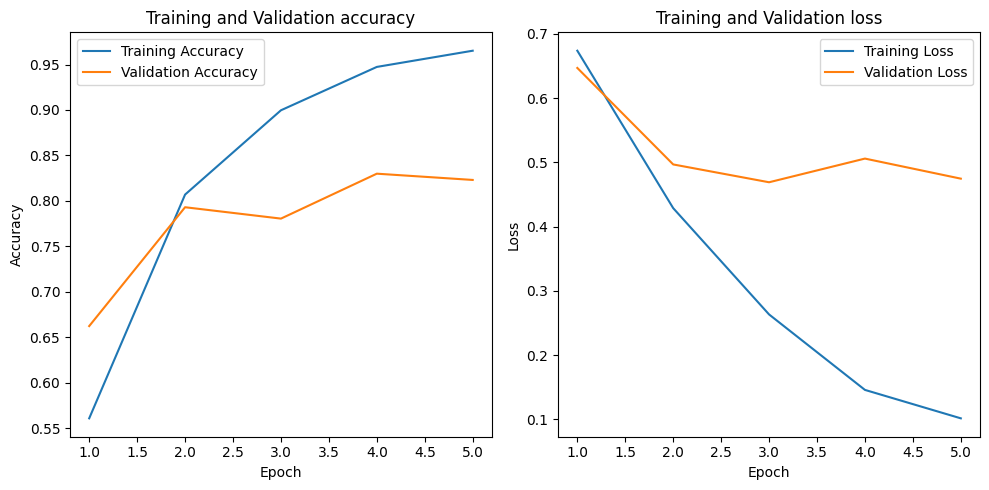

In [61]:
plotLearningCurve(lstm_history,n_epochs)

In [62]:
print("Evaluate Model Performance on Test set")
result = model.evaluate(pad_test,ytest)
print(dict(zip(model.metrics_names, result)))

Evaluate Model Performance on Test set
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8200 - loss: 0.5160
{'loss': 0.511398434638977, 'compile_metrics': 0.8149999976158142}


## Confusion Matrix

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


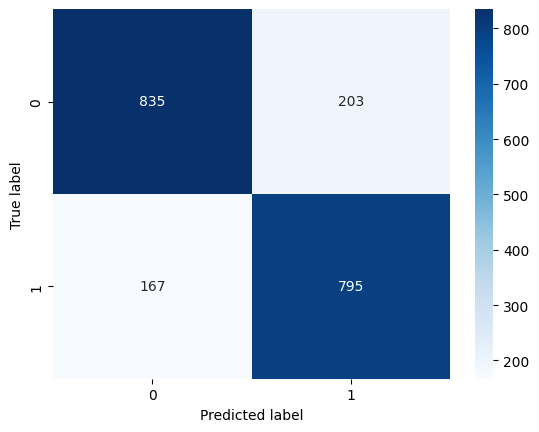

In [63]:
#Generate predictions for the test dataset
ypred = model.predict(pad_test)
ypred = ypred>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(ytest, ypred)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

## Classification Report

In [67]:
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.83      0.80      0.82      1038
           1       0.80      0.83      0.81       962

    accuracy                           0.81      2000
   macro avg       0.81      0.82      0.81      2000
weighted avg       0.82      0.81      0.82      2000



# BERT

BERT (Bidirectional Encoder Representations from Transformers) is a pre-trained language model that understands context in both directions, making it highly effective for a variety of natural language processing tasks.

We'll adopt a transfer learning approach, using the BERT language model. The approach consists on:
- Download the pretrained model on a large dataset
- Fine-tune the model with the given dataset (IMDB)

In [43]:
train, test= train_test_split(df, test_size=0.2, random_state=42)
Xtrain, ytrain = train['review'], train['sentiment']
Xtest, ytest = test['review'], test['sentiment']
#splitting the train set into train and validation
Xtrain,Xval,ytrain,yval=train_test_split(Xtrain,ytrain,
                                             test_size=0.2,random_state=10)

In [45]:

# Load a DistilBERT model.
preset = 'distil_bert_base_en_uncased'

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,sequence_length=160)

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(
    preset,
    preprocessor=preprocessor,
    num_classes=2
    )

classifier.summary()

Preprocessor: "distil_bert_preprocessor_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_1 (GetItem)          │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item_1[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics= ["accuracy"]
)


In [47]:
history = classifier.fit(
    x=Xtrain,
    y=ytrain,
    batch_size=64,
    epochs=3,
    validation_data=(Xval, yval)
)

Epoch 1/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 190s 253ms/step - accuracy: 0.7840 - loss: 0.4358 - val_accuracy: 0.8804 - val_loss: 0.2952
Epoch 2/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 123s 245ms/step - accuracy: 0.9037 - loss: 0.2460 - val_accuracy: 0.8820 - val_loss: 0.3013
Epoch 3/3
500/500 ━━━━━━━━━━━━━━━━━━━━ 123s 245ms/step - accuracy: 0.9401 - loss: 0.1570 - val_accuracy: 0.8721 - val_loss: 0.3709


### BERT Learning Curve x Epoch

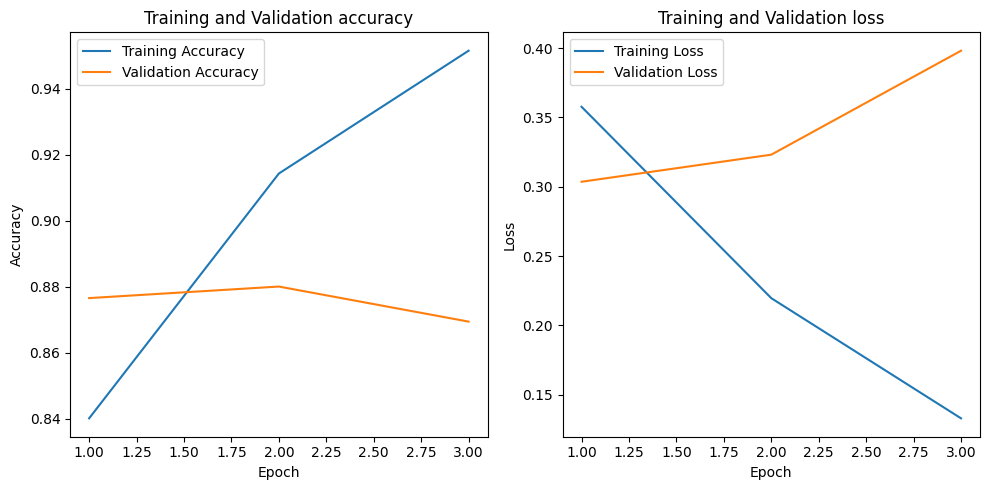

In [ ]:
plotLearningCurve(history,3)

In [ ]:
print("Evaluate Model Performance on Test set")
result = classifier.evaluate(Xtest, ytest)
print(dict(zip(classifier.metrics_names, result)))

Evaluate Model Performance on Test set
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.8690 - loss: 0.4029
{'loss': 0.40242117643356323, 'compile_metrics': 0.8683000206947327}


### Confusion Matrix

313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step


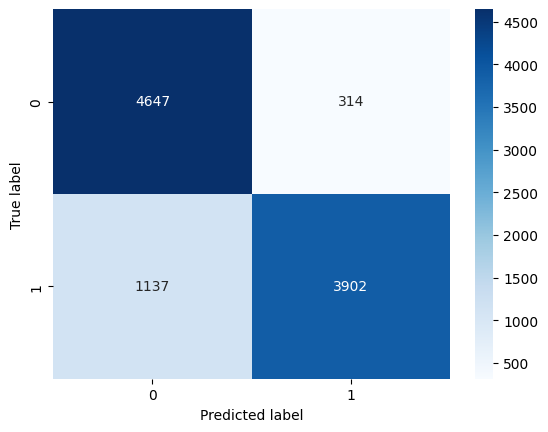

In [ ]:
#Generate predictions for the test dataset
ypred = classifier.predict(Xtest)
ypred = (ypred>0.5).astype(int)
#Get the confusion matrix
cf_matrix = confusion_matrix(ytest, np.argmax(ypred, axis=1))
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

### Classification Report

In [ ]:
print(classification_report(ytest, np.argmax(ypred, axis=1)))

              precision    recall  f1-score   support

           0       0.80      0.94      0.86      4961
           1       0.93      0.77      0.84      5039

    accuracy                           0.85     10000
   macro avg       0.86      0.86      0.85     10000
weighted avg       0.86      0.85      0.85     10000



## Summary

|Method|Training Accuracy| Validation Accuracy|Test Accuracy|
|:----|:--------:|:--------:|:--------:|
|**LSTM** | 0.9652|    0.8231 | 8200 |
|**BERT** | 0.9401 | 0.8721 | 0.8690 |


## Conclusion

- Both Models perform reasonably well on the task
- Transfer learning can greatly reduce development time, taking advantage of pretrained models, on large datasets
-  With less development work, and fewer epoch, BERT achives higher test accuracy scores, when compared with LSTM

### Future Work

For future work, we could focus on alternatives, and also train GPT's model and compare it's performance. Differently from BERT, it's not open source, using the model is a paid API service.